### (c) Edouard Fouché, 2020 - GNU AFFERO GENERAL PUBLIC LICENSE, Version 3 
See also: https://edouardfouche.com/arXiv-and-the-Information-Explosion/

Import some packages and define some style. 

In [1]:
import math
import json 
import copy
from datetime import datetime

import pandas as pd
import numpy as np
from scipy import interpolate

import matplotlib as mpl
from matplotlib import cm
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

In [2]:
# Some styling 
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['text.latex.preamble'] = r'\usepackage{libertine}' 
mpl.rc('font', family='serif')
mpl.rcParams['ps.usedistiller'] = 'xpdf' 
plt.style.use('seaborn-notebook')
plt.rcParams['axes.titlesize'] = '25'
plt.rcParams['axes.labelsize'] = '25'
plt.rcParams['legend.fontsize'] = '15'
plt.rcParams['xtick.labelsize'] = '15'
plt.rcParams['ytick.labelsize'] = '15'

# Some colors
uiucblue = (19/255,42/255,76/255)
uiucred = (232/255,74/255,39/255)
kitgreen = (50/255,161/255,137/255)

In [3]:
!pip freeze

absl-py==0.9.0
alabaster==0.7.12
anaconda-client==1.6.3
anaconda-navigator==1.6.4
anaconda-project==0.6.0
appdirs==1.4.3
arff==0.9
asn1crypto==1.3.0
astor==0.8.0
astroid==2.3.3
astropy==2.0.1
attrs==19.3.0
Babel==2.8.0
backcall==0.1.0
backports.shutil-get-terminal-size==1.0.0
backports.weakref==1.0rc1
beautifulsoup4==4.6.0
bitarray==0.8.1
bkcharts==0.2
blaze==0.10.1
bleach==3.1.0
blis==0.4.1
bokeh==1.4.0
boto==2.48.0
boto3==1.11.9
botocore==1.14.9
Bottleneck==1.2.1
cachetools==4.0.0
catalogue==1.0.0
certifi==2019.11.28
cffi==1.13.2
chardet==3.0.4
Click==7.0
cloudpickle==1.2.2
clyent==1.2.2
colorama==0.3.9
conda==4.8.2
conda-package-handling==1.6.0
contextlib2==0.5.5
cryptography==2.8
cycler==0.10.0
cymem==2.0.3
Cython==0.26
cytoolz==0.10.1
dask==2.10.1
datashape==0.5.4
dautil==0.0.1b1
dcor==0.1.5
decorator==4.4.1
defusedxml==0.6.0
distributed==2.10.0
docutils==0.15.2
en-core-web-sm==2.2.5
entrypoints==0.3
et-xmlfile==1.0.1
fastcache==1.0.2
Flask==1.1.1
Flask-Cors==3.0.8
fsspec==0.6.2
f

We need to parse the JSON file. It may be tempting to do something like this:

In [4]:
# pd.read_json('arxiv-metadata-oai-snapshot.json', lines=True) # leads to memory error

This will likely lead to a memory error, as you are reading a 2.9GB JSON file. 

It is better to parse this JSON file the "old school" way: 

In [5]:
f = open('arxiv-metadata-oai-snapshot.json')

i = 0
ignores = ['abstract', 'authors_parsed', 'versions']  # let's ignore those fields for now
record = f.readline()
results = []

while (record !=  ''): # do this until file is empty
    if (i%100000) == 0:
        print("reached %s at %s"%(i,datetime.now().strftime("%d/%m/%Y %H:%M:%S")))
    res = json.loads(record) 
        
    version = res["versions"][0] # take only the first version
    
    #for version in res["versions"]: # If you want to take into account different versions.
    #newres = copy.deepcopy(res)
    
    res['version'] = version['version']
    res['created'] = version['created']
    
    for ignore in ignores: # save space
        del res[ignore]
    #data.loc[i] = res # avoid DataFrame.append(), this is too slow
    results.append(res)
    
    record = f.readline()  # go for the next record 
    i += 1

data = pd.DataFrame(results)

reached 0 at 19/11/2020 14:14:05
reached 100000 at 19/11/2020 14:14:07
reached 200000 at 19/11/2020 14:14:09
reached 300000 at 19/11/2020 14:14:12
reached 400000 at 19/11/2020 14:14:14
reached 500000 at 19/11/2020 14:14:16
reached 600000 at 19/11/2020 14:14:19
reached 700000 at 19/11/2020 14:14:21
reached 800000 at 19/11/2020 14:14:23
reached 900000 at 19/11/2020 14:14:25
reached 1000000 at 19/11/2020 14:14:28
reached 1100000 at 19/11/2020 14:14:30
reached 1200000 at 19/11/2020 14:14:33
reached 1300000 at 19/11/2020 14:14:35
reached 1400000 at 19/11/2020 14:14:38
reached 1500000 at 19/11/2020 14:14:40
reached 1600000 at 19/11/2020 14:14:42
reached 1700000 at 19/11/2020 14:14:44


We keep each record in a `list` and then create a `DataFrame` (it is much fast than appending the DataFrame over and over). We now have a `DataFrame` with around 1.7M records! 

Let's now extract the main category for each paper and the year of creation. 

In [6]:
data.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,update_date,version,created
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,2008-11-26,v1,"Mon, 2 Apr 2007 19:18:42 GMT"
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,2008-12-13,v1,"Sat, 31 Mar 2007 02:26:18 GMT"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,2008-01-13,v1,"Sun, 1 Apr 2007 20:46:54 GMT"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,2007-05-23,v1,"Sat, 31 Mar 2007 03:16:14 GMT"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,2013-10-15,v1,"Mon, 2 Apr 2007 18:09:58 GMT"


In [7]:
data.shape

(1774609, 13)

In [8]:
data['maincat'] = [x.split(" ")[0].split(".")[0] for x in data["categories"]] # let's get the main categories
data['maincat'].unique()

array(['hep-ph', 'math', 'physics', 'cond-mat', 'gr-qc', 'astro-ph',
       'hep-th', 'hep-ex', 'nlin', 'q-bio', 'quant-ph', 'cs', 'nucl-th',
       'math-ph', 'hep-lat', 'nucl-ex', 'q-fin', 'stat', 'eess', 'econ',
       'acc-phys', 'adap-org', 'alg-geom', 'ao-sci', 'atom-ph', 'bayes-an',
       'chao-dyn', 'chem-ph', 'cmp-lg', 'comp-gas', 'dg-ga', 'funct-an',
       'mtrl-th', 'patt-sol', 'plasm-ph', 'q-alg', 'solv-int', 'supr-con'], dtype=object)

In [9]:
len(data['maincat'].unique())

38

In [10]:
data["date"] = pd.to_datetime(data["created"]) # this takes some time
data['year'] = pd.DatetimeIndex(data['date']).year 
data['year'].unique() # some papers are before 1991?

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020, 1994, 1995, 1996, 1993, 1997, 1998, 1999, 1992,
       2000, 2001, 2002, 2003, 2004, 2005, 2006, 1990, 1991, 1988, 1989,
       1986])

We can see that there are 38 categories and also some papers created before `1991`, the year [arXiv][arXiv] was created. Let's clean that up!

In [53]:
# Some cleaning in categories

data["maincat"] = data["maincat"].replace("hep-ex", "hep-*")
data["maincat"] = data["maincat"].replace("hep-lat", "hep-*")
data["maincat"] = data["maincat"].replace("hep-ph", "hep-*")
data["maincat"] = data["maincat"].replace("hep-th", "hep-*")

data["maincat"] = data["maincat"].replace("math-ph", "math")
data["maincat"] = data["maincat"].replace("nucl-th", "nucl")
data["maincat"] = data["maincat"].replace("q-fin", "q-fin+econ")
data["maincat"] = data["maincat"].replace("econ", "q-fin+econ")

data["maincat"] = data["maincat"].replace("physics", "physics+gr-qc+nlin+nucl+quant-ph")
data["maincat"] = data["maincat"].replace("gr-qc", "physics+gr-qc+nlin+nucl+quant-ph")
data["maincat"] = data["maincat"].replace("nlin", "physics+gr-qc+nlin+nucl+quant-ph")
data["maincat"] = data["maincat"].replace("nucl", "physics+gr-qc+nlin+nucl+quant-ph")
data["maincat"] = data["maincat"].replace("quant-ph", "physics+gr-qc+nlin+nucl+quant-ph")

In [54]:
# Year 2020 is not over yet, so let's discard it, arXiv started in 1991
toplot = data[(data["year"] >= 1991) & (data["year"] <= 2019)]

In [55]:
# Get the cumulative counts for each main category per year
cumulative = toplot.groupby(["year", "maincat"])[["id"]].count().reset_index().pivot_table(
    index=["year"], columns=["maincat"]).fillna(0).cumsum()

# Get the max for each category
maxcounts = cumulative.max().reset_index()[["maincat", 0]].set_index("maincat")

# Some formatting
cumulative.columns =  cumulative.columns.droplevel(0)
cumulative.columns.name = None

# Let's keep the categories with more than 10000 papers 
tokeep = maxcounts[maxcounts[0] > 10000].sort_values(0).index
tokeep

Index(['q-bio', 'stat', 'cs', 'hep-*', 'astro-ph', 'cond-mat',
       'physics+gr-qc+nlin+nucl+quant-ph', 'math'],
      dtype='object', name='maincat')

In [56]:
# So there were more than 150K submissions in 2019!
cumulative.T.sum()[2019] - cumulative.T.sum()[2018] # -> 155917

155917.0

So we now have the cumulative counts for each main category. As we can see, there were more than 155K submissions in 2019!

<IPython.core.display.Javascript object>


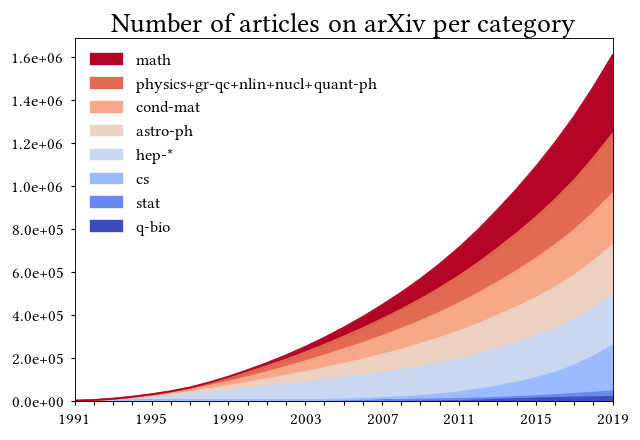

In [57]:
%matplotlib notebook

cumulative[tokeep].plot.area(cmap="coolwarm")
plt.title("Number of articles on arXiv per category")
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.xticks([1991+x for x in range(2019-1991+1)], 
           [1991+x  if x%4==0 else "" for x in range(2019-1991+1)])
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles[::-1], labels[::-1], frameon=False)
plt.xlabel("") 
plt.tight_layout()
plt.savefig("plots/counts_arxiv.pdf")

In [58]:
# Relative counts
relative = copy.deepcopy(cumulative[tokeep])
yearsum = cumulative[tokeep].T.sum()
relativeT = relative.T
for col in relativeT.columns:
    relativeT[col] = relativeT[col] / yearsum[col]
relative = relativeT.T

<IPython.core.display.Javascript object>


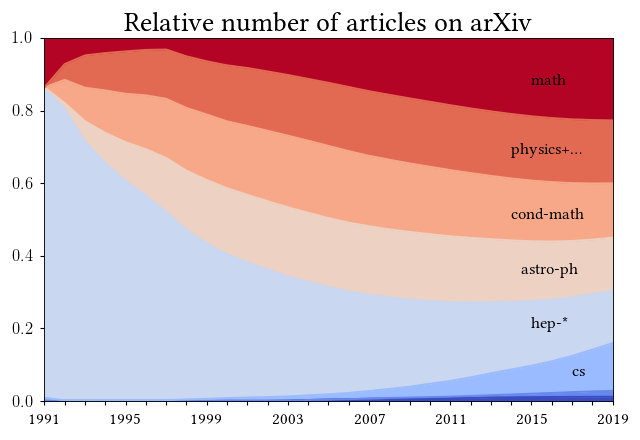

In [59]:
%matplotlib notebook

ax = relative[tokeep].plot.area(cmap="coolwarm")
plt.tight_layout()
plt.title("Relative number of articles on arXiv")
plt.gca().yaxis.set_major_formatter(mtick.ScalarFormatter())
plt.xticks([1991+x for x in range(2019-1991+1)], 
           [1991+x  if x%4==0 else "" for x in range(2019-1991+1)])
plt.gca().get_legend().remove()
plt.xlabel("")
plt.ylim(0,1)

plt.gca().text(2015, 0.87, "math", fontsize=15)
plt.gca().text(2014, 0.68, "physics+...", fontsize=15)
plt.gca().text(2014, 0.50, "cond-math", fontsize=15)
plt.gca().text(2014.5, 0.35, "astro-ph", fontsize=15)
plt.gca().text(2015, 0.20, "hep-*", fontsize=15)
plt.gca().text(2017, 0.07, "cs", fontsize=15)

plt.tight_layout()
plt.savefig("plots/relative_counts_arxiv.pdf")

<IPython.core.display.Javascript object>


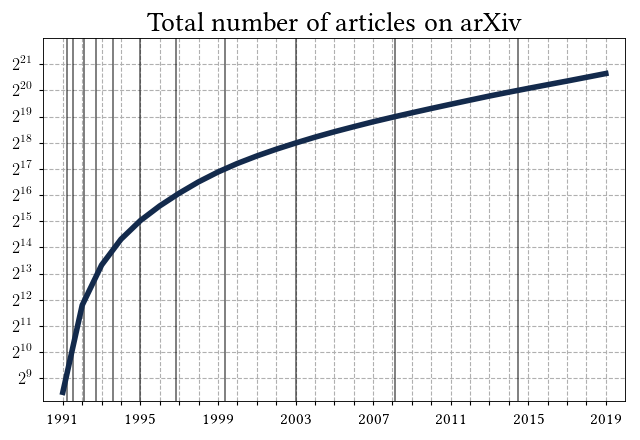

In [60]:
%matplotlib notebook

y = np.array(cumulative.T.sum())

ref = pd.Series([val for val in y])
ref.index = cumulative[tokeep].T.sum().index
plt.plot(ref, color=uiucblue, linewidth=5)

ax = plt.gca()
ax.set_yscale('log', basey=2)
plt.yticks([2**x for x in range(22)])
plt.xticks([1991+x for x in range(2019-1991+1)], 
           [1991+x  if x%4==0 else "" for x in range(2019-1991+1)])
plt.title("Total number of articles on arXiv")

f = interpolate.interp1d(y, ref.index)
for x in range(10,21):
    plt.vlines(f(2**x), 0.5, 5*10**6, alpha=0.5)
    
plt.ylim((1.1*2**8,2**22))
plt.xlim((1990, 2020))
plt.grid(linestyle="--")

plt.tight_layout()
plt.savefig("plots/total_counts_arxiv.pdf")

<IPython.core.display.Javascript object>


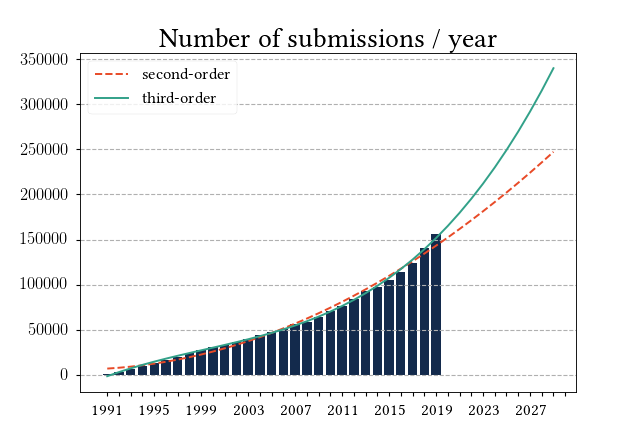

In [61]:
%matplotlib notebook

sums = cumulative.T.sum()
diffs = copy.deepcopy(sums)
diffs = diffs.sort_index()
for x in range(1992, 2020): # get the number of new submission per year
    diffs[x] = diffs[x] - sums[x-1]
plt.bar(diffs.index, diffs, color=uiucblue)

x = np.array(diffs.index)
y = np.array(diffs)

# Let's fit a second order polynomial
z = np.polyfit(x, y, 2, full=True)
fit2 = np.poly1d(z[0])
fitted = pd.Series([fit2(val) for val in list(x) + [2020 + x for x in range(10)]])
fitted.index = list(diffs.index) + [2020 + x for x in range(10)]
plt.plot(fitted, color=uiucred, linestyle="--", label="second-order")

# Let's fit a third order polynomial
z = np.polyfit(x, y, 3, full=True)
fit3 = np.poly1d(z[0])
fitted = pd.Series([fit3(val) for val in list(x) + [2020 + x for x in range(10)]])
fitted.index = list(diffs.index) + [2020 + x for x in range(10)]
plt.plot(fitted, color=kitgreen, label="third-order")

plt.xticks([1991+x for x in range(2030-1991+1)], 
           [1991+x  if x%4==0 else "" for x in range(2030-1991+1)])
plt.legend()

plt.title("Number of submissions / year")
plt.grid(linestyle="--", axis="y")

plt.savefig("plots/submissions_per_year_arxiv_forecast.pdf")

In [41]:
[fit2(2020 + x) for x in range(10)] # forecasted evolution of numnber of submissions

[152233.93486642838,
 161627.3021351099,
 171312.38100588322,
 181289.17147862911,
 191557.67355334759,
 202117.88722991943,
 212969.81250858307,
 224113.44938910007,
 235548.79787158966,
 247275.85795605183]

In [42]:
# Expected total number of submission by 2030
int(diffs.sum() + sum([fit2(2020 + x) for x in range(10)])) # -> 3619959

3619959

In [43]:
int(diffs.sum() + sum([fit3(2020 + x) for x in range(10)])) # -> 4087884

4087884

# Closer look -> Computer Science

In [44]:
# Let's get those for computer science
data_cs = copy.deepcopy(data[data['maincat'] == "cs"])
data_cs.loc[:,'subcat'] = [x.split(" ")[0].split(".")[1] for x in data_cs["categories"]]
data_cs['subcat'].unique()

array(['NE', 'DS', 'CE', 'IT', 'CC', 'DM', 'CR', 'NI', 'PF', 'LG', 'CY',
       'CG', 'CV', 'SE', 'OH', 'PL', 'AI', 'IR', 'GT', 'LO', 'SC', 'DC',
       'CL', 'HC', 'AR', 'DL', 'MS', 'RO', 'DB', 'GL', 'MA', 'MM', 'OS',
       'NA', 'SD', 'GR', 'FL', 'SI', 'SY', 'ET'], dtype=object)

In [45]:
# arXiv started in 1991, and year 2020 is not over yet 
toplot = data_cs[(data_cs["year"] >= 1991) & (data_cs["year"] <= 2019)]

In [46]:
cumulative = toplot.groupby(["year", "subcat"])[["id"]].count().reset_index().pivot_table(
    index=["year"], columns=["subcat"]).fillna(0).cumsum()
cumulative.columns =  cumulative.columns.droplevel(0)
cumulative.columns.name = None

In [47]:
cumulative.T.sum()[2019] - cumulative.T.sum()[2018]

43939.0

In [48]:
tokeep = cumulative.max().sort_values(0).index # sort by decreasing

<IPython.core.display.Javascript object>


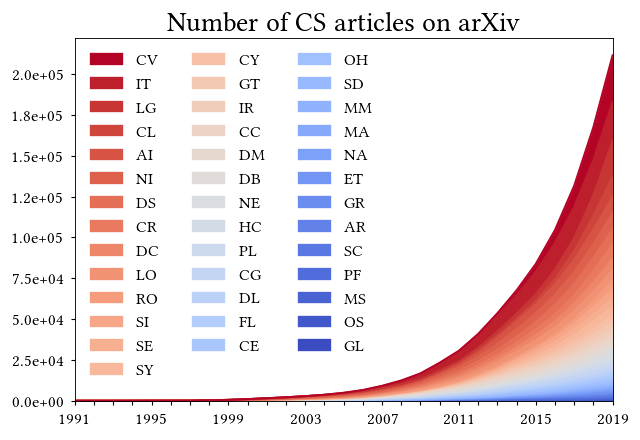

In [49]:
%matplotlib notebook

cumulative[tokeep].plot.area(cmap="coolwarm")
plt.title("Number of CS articles on arXiv")
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.xticks([1991+x for x in range(2019-1991+1)], 
           [1991+x  if x%4==0 else "" for x in range(2019-1991+1)])
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles[::-1], labels[::-1], ncol=3, frameon=False)
plt.xlabel("")

plt.tight_layout()
plt.savefig("plots/counts_arxiv_cs.pdf")

In [50]:
# Relative counts
relative = copy.deepcopy(cumulative)
yearsum = cumulative.T.sum()
relativeT = relative.T
for col in relativeT.columns:
    relativeT[col] = relativeT[col] / yearsum[col]
relative = relativeT.T

<IPython.core.display.Javascript object>


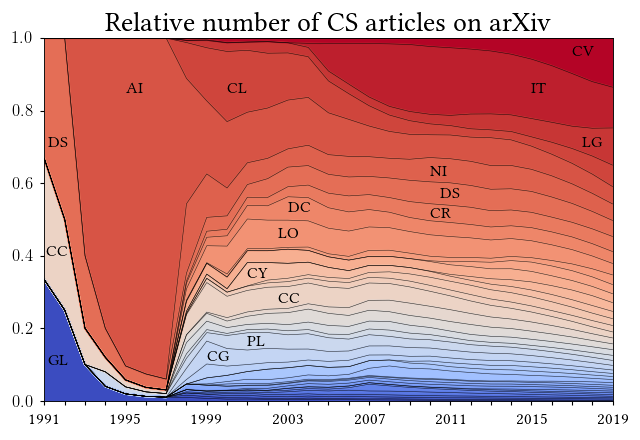

In [51]:
%matplotlib notebook

ax = relative[tokeep].plot.area(cmap="coolwarm")
relative[tokeep].plot(stacked=True, color="black", alpha=0.8, ax=ax, linewidth=0.5)
plt.title("Relative number of CS articles on arXiv")
plt.gca().yaxis.set_major_formatter(mtick.ScalarFormatter())
plt.xticks([1991+x for x in range(2019-1991+1)], 
           [1991+x  if x%4==0 else "" for x in range(2019-1991+1)])
plt.gca().get_legend().remove()
plt.xlabel("")
plt.ylim(0,1)

plt.gca().text(2017, 0.95, "CV", fontsize=15)
plt.gca().text(2015, 0.85, "IT", fontsize=15)
plt.gca().text(2017.5, 0.70, "LG", fontsize=15)
plt.gca().text(2000, 0.85, "CL", fontsize=15)
plt.gca().text(1995, 0.85, "AI", fontsize=15)
plt.gca().text(2010, 0.62, "NI", fontsize=15)
plt.gca().text(2010.5, 0.56, "DS", fontsize=15)
plt.gca().text(1991.2, 0.7, "DS", fontsize=15)
plt.gca().text(2010, 0.505, "CR", fontsize=15)
plt.gca().text(2003, 0.52, 'DC', fontsize=15)
plt.gca().text(2002.5, 0.45, 'LO', fontsize=15)
plt.gca().text(2001, 0.34, 'CY', fontsize=15)
plt.gca().text(1991.1, 0.40, 'CC', fontsize=15)
plt.gca().text(2002.5, 0.27, 'CC', fontsize=15)
plt.gca().text(2001, 0.15, 'PL', fontsize=15)
plt.gca().text(1999, 0.11, 'CG', fontsize=15)
plt.gca().text(1991.2, 0.1, 'GL', fontsize=15)

plt.tight_layout()

plt.savefig("plots/relative_counts_arxiv_cs.pdf")

In [31]:
# How many CS articles will be have by 2030? 